In [1]:
%matplotlib inline
import random
import numpy as np
from pyDOE import *
import pandas as pd
import pyDOE as pyd
from pyomo.environ import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Problem 1

 I used latin hypercube sampling method for generating dataset. Since there are two features, I generated 50 sample, 40 for training purpose and 10 for testing purpose.

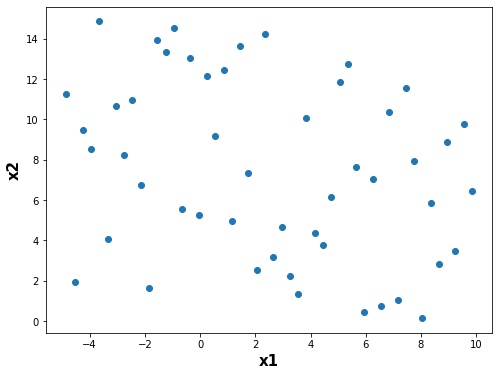

In [2]:
np.random.seed(42)
n = 2  #dimension
N = 20*n + 10  #samples
xbounds = np.array([[-5,10],[0,15]]) #[Bounds]

# print(xbounds)
Xsc = pyd.lhs(n, samples=N, criterion='centermaximin')

Xsc[:,0] = (Xsc[:,0]*(xbounds[0,1]-xbounds[0,0])+xbounds[0,0])
Xsc[:,1] = (Xsc[:,1]*(xbounds[1,1]-xbounds[1,0])+xbounds[1,0])
# print(Xsc)
X = Xsc
plt.figure(figsize=(8,6))
plt.plot(X[:, 0], X[:, 1], 'o')
plt.xlabel('x1', fontsize = 15, fontweight='bold')
plt.ylabel('x2', fontsize = 15, fontweight='bold');

# Black-box Function

In [3]:
def bbs(x):
    y = (
        10 + 10*(1 - 1/(8*np.pi))*np.cos(x[:,0]) + 
            (x[:,1] - 5.1*x[:,0]**2/(16*np.pi**2) + 5*x[:,0]/np.pi - 6)**2)
    return y
Y = bbs(X)

# Problem 2(a)

# Scaling between 0-1

In [4]:
# X value
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
X_scal = (X - mins[:]) / (maxs[:] - mins[:])

# Y value
y_mins = np.min(Y)
y_maxs = np.max(Y)
Y_scal = (Y - y_mins) / (y_maxs - y_mins)

# First Generalized Linear Regression
## [1, $x_{1}$, $x_{2}$, $x_{1}^{2}$, $x_{2}^{2}$, $x_{1}^{4}$, cos$x_{1}$, $x_{1}$$x_{2}$]

In [5]:
def firstGlrf(X,y):
    
    np.random.seed(42)
#     kf = KFold(n_splits=5, random_state=1, shuffle=True)
    cv = 5
    allCoeff = []
    trainError = []
    
    for i in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = i)

        # Model 
        model = ConcreteModel()

        model.s = list(range(len(X_train)))
        model.yact = y_train
        model.x1 = X_train[:,0]
        model.x2 = X_train[:,1]


        model.ypred = Var(model.s, within=NonNegativeReals)
    
        model.a = np.arange(8)
        model.b = Var(model.a, within=Reals)

        # Constraints
        def con_rule(model,i): 
            return (1*model.b[0] + model.b[1]*model.x1[i] + model.b[2]*model.x2[i]
                    + model.b[3]*(model.x1[i]**2) + model.b[4]*(model.x2[i]**2)
                    + model.b[5]*(model.x1[i]**4) + model.b[6]*cos(model.x1[i])
                    + model.b[7]*(model.x1[i]*model.x2[i])) - model.ypred[i] == 0

        model.con = Constraint(model.s, rule=con_rule)
        
        # Objective Function
        def obj_rule(model):
            alpha = 0.1
            return (sum((model.ypred[i]-model.yact[i])**2 for i in model.s)/len(model.s) 
                    + alpha*sum(abs(model.b[i]) for i in model.b)) # not use abs

        model.obj = Objective(rule=obj_rule) 

        # Solver
        solver = SolverFactory('baron')
        solver.solve(model)

        
        # Error for training 
        err_train = value(model.obj)
        trainError.append(err_train)
        
        # Coeff for each fold
        coeff = []
        for i in range(8):
    #         print(value(model.b[i]))
            coeff.append(value(model.b[i]))
        allCoeff.append(coeff)
        
    
    # Average training error
    avg_trainError = np.mean(trainError)

    
    # Define model for testing
    def val_data(x1, x2, coeff):
        y_all = []
        for i in coeff:
            y = (1*i[0] + i[1]*x1 + i[2]*x2
                    + i[3]*(x1**2) + i[4]*(x2**2)
                    + i[5]*(x1**4) + i[6]*np.cos(x1)
                    + i[7]*(x1*x2))

            y_all.append(y)
        return y_all

    # y pred 
    y_val_pred = val_data(X_test[:, 0], X_test[:,1], allCoeff)

    
    valError = []
    for m in range(len(y_val_pred)):
        err_val = sum((y_test[i] - y_val_pred[m][i])**2 for i in range(len(y_test)))
        valError.append(err_val)
    
    # Average validation error
    avg_valError = np.mean(valError)
    
    
    performance_score = {'Train_Error' : trainError,
                         'Avg_Train_Error' : avg_trainError,
                         'Validation_Error' : valError,
                         'Avg_Validation_Error' : avg_valError,
                         'Optimum_Validation_Error' : min(valError),
                         'Optimum_Coeff' : allCoeff[valError.index(min(valError))],
                         'All_Coeff' : np.array(allCoeff),
                         }

    return performance_score

In [6]:
# Run the function using X scale and 
firstGlrf_result = firstGlrf(X_scal,Y)

print('='*80)
print('Mean Validation Error: ', firstGlrf_result['Avg_Validation_Error'])
print('-'*80)
print('Validation Error:')
print(firstGlrf_result['Validation_Error'])
print('='*80)

Mean Validation Error:  3616.1713120726517
--------------------------------------------------------------------------------
Validation Error:
[5048.008277331076, 1763.0088541809291, 1463.0222700143033, 1677.0934945693518, 8129.7236642676]


# Second Generalized Linear Regression
## [1, $x_{1}$, $x_{2}$, $x_{1}^{2}$, $x_{1}^{3}$, $x_{2}^{2}$, $x_{2}^{3}$, $x_{1}$$x_{2}$, $x_{1}^{2}$$x_{2}$,  $x_{1}$$x_{2}^{2}$]

In [7]:
def secondGlrf(X,y):
    np.random.seed(42)
    cv = 5
    allCoeff = []
    trainError = []
    
    for i in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)

        # Model 
        model = ConcreteModel()

        model.s = list(range(len(X_train)))
        model.yact = y_train
        model.x1 = X_train[:,0]
        model.x2 = X_train[:,1]


        model.ypred = Var(model.s, within=NonNegativeReals)
    
        model.a = np.arange(10)
        model.b = Var(model.a, within=Reals)

        # Constraints
        def con_rule(model,i): 
            return (1*model.b[0] + model.b[1]*model.x1[i] + model.b[2]*model.x2[i]
                    + model.b[3]*(model.x1[i]**2) + model.b[4]*(model.x1[i]**3)
                    + model.b[5]*(model.x2[i]**2) + model.b[6]*(model.x2[i]**3)
                    + model.b[7]*(model.x1[i]*model.x2[i]) + model.b[8]*((model.x1[1]**2)*model.x2[i])
                    + model.b[9]*(model.x1[i]*(model.x2[i]**2))) - model.ypred[i] == 0

        model.con = Constraint(model.s, rule=con_rule)

        def obj_rule(model):
            alpha = 0.1
            return (sum((model.ypred[i]-model.yact[i])**2 for i in model.s)/len(model.s) 
                    + alpha*sum(abs(model.b[i]) for i in model.b))

        model.obj = Objective(rule=obj_rule) 

        # Solver
        solver = SolverFactory('baron')
        solver.solve(model)

        
        # Error for training 
        err_train = value(model.obj)
        trainError.append(err_train)
        
        # Coeff for each fold
        coeff = []
        for i in range(10):
    #         print(value(model.b[i]))
            coeff.append(value(model.b[i]))
        allCoeff.append(coeff)
        
    
    # Average training error
    avg_trainError = np.mean(trainError)

    
    # Define model for testing
    
    def val_data(x1, x2, coeff):
        y_all = []
        for i in coeff:
            y = (1*i[0] + i[1]*x1 + i[2]*x2
                    + i[3]*(x1**2) + i[4]*(x1**3)
                    + i[5]*(x2**2) + i[6]*(x2**3)
                    + i[7]*(x1*x2) + i[8]*((x1**2)*x2)
                    + i[9]*(x1*(x2**2)))
            

            y_all.append(y)
        return y_all


    # y pred 
    y_val_pred = val_data(X_test[:, 0], X_test[:,1], allCoeff)

    
    valError = []
    for m in range(len(y_val_pred)):
        err_val = sum((y_test[i] - y_val_pred[m][i])**2 for i in range(len(y_test)))
        valError.append(err_val)
    
    # Average validation error
    avg_valError = np.mean(valError)
    
    
    performance_score = {'Train_Error' : trainError,
                         'Avg_Train_Error' : avg_trainError,
                         'Validation_Error' : valError,
                         'Avg_Validation_Error' : avg_valError,
                         'Optimum_Validation_Error' : min(valError),
                         'Optimum_Coeff' : allCoeff[valError.index(min(valError))],
                         'All_Coeff' : np.array(allCoeff),
                         }

    return performance_score

In [8]:
# Run the function using X scale and 
secondGlrf_result = secondGlrf(X_scal,Y)

print('='*80)
print('Mean Validation Error: ', secondGlrf_result['Avg_Validation_Error'])
print('-'*80)
print('Validation Error: ')
print(secondGlrf_result['Validation_Error'])
print('='*80)

Mean Validation Error:  4634.587144579739
--------------------------------------------------------------------------------
Validation Error: 
[6107.0576862976895, 1694.1635375962705, 1804.3527780427175, 1977.4586533529616, 11589.903067609055]


# Problem 2(b)

Based on the Validation error I choose first function

In [9]:
def bestFitFunc(X,y):
    coeff = []

    
    # Model 
    model = ConcreteModel()

    model.s = list(range(len(X)))
    model.yact = y
    model.x1 = X[:,0]
    model.x2 = X[:,1]


    model.ypred = Var(model.s, within=NonNegativeReals)

    model.a = np.arange(8)
    model.b = Var(model.a, within=Reals)

    def con_rule(model,i): 
        return (1*model.b[0] + model.b[1]*model.x1[i] + model.b[2]*model.x2[i]
                + model.b[3]*(model.x1[i]**2) + model.b[4]*(model.x2[i]**2)
                + model.b[5]*(model.x1[i]**4) + model.b[6]*cos(model.x1[i])
                + model.b[7]*(model.x1[i]*model.x2[i])) - model.ypred[i] == 0

    model.con = Constraint(model.s, rule=con_rule)

    def obj_rule(model):
        alpha = 0.1
        return (sum((model.ypred[i]-model.yact[i])**2 for i in model.s)/len(model.s) 
                + alpha*sum(abs(model.b[i]) for i in model.b))

    model.obj = Objective(rule=obj_rule) 

    # Solver
    solver = SolverFactory('baron')
    solver.solve(model)

        
    # Error for training 
    opt_val = value(model.obj)
  
        
    # Coeff for each fold
    for i in range(8):
        a = value(model.b[i])
        coeff.append(a)
    
    performance_score = {'Optimized_Val' : opt_val,
                         'Coeff' : coeff
                         }

    return performance_score

In [10]:
# Report optimal parameters and objective functions
reFit = bestFitFunc(X, Y)
print('='*80)
print('Optimal Parameters: ') 
print(reFit['Coeff'])
print('-'*80)
print('Objective Function: ', reFit['Optimized_Val'])
print('='*80)

Optimal Parameters: 
[56.09716258693343, -19.083100622193598, -13.852687365702325, 2.3894965398554637, 1.0654231515896664, -0.0069796268656459525, 10.112406868047742, 2.943823138120639]
--------------------------------------------------------------------------------
Objective Function:  27.23035438699241


# Problem 2(c)

In [11]:
def opt_best_func(n, samples, coeff):
    np.random.seed(42)
    
    Xnew = pyd.lhs(n, samples, criterion='centermaximin')
    Ynew = bbs(Xnew)



    model = ConcreteModel()
    model.x1 = Xnew[:, 0]
    model.x2 = Xnew[:, 1]

    model.s = list(range(samples))
    model.b = coeff
    model.yact = Ynew
    model.ypred = Var(model.s, within=NonNegativeReals)


    def con_rule(model,i): 
        return (1*model.b[0] + model.b[1]*model.x1[i] + model.b[2]*model.x2[i]
                    + model.b[3]*(model.x1[i]**2) + model.b[4]*(model.x2[i]**2)
                    + model.b[5]*(model.x1[i]**4) + model.b[6]*cos(model.x1[i])
                    + model.b[7]*(model.x1[i]*model.x2[i])) - model.ypred[i] == 0

    model.con = Constraint(model.s, rule=con_rule)

    def obj_rule(model):
    #     alpha = 0.1
        return (sum((model.ypred[i]-model.yact[i])**2 for i in model.s))



    model.obj = Objective(rule=obj_rule, sense = minimize) 

    # Solver
    solver = SolverFactory('baron')
    solver.solve(model)
    # model.pprint()
    opt_value = value(model.obj)
    return opt_value

In [12]:
# for differnt number of sample
num = [5, 10, 15, 20, 30, 50, 100]
obj_val = []
for i in num:
    val = opt_best_func(2, i, reFit['Coeff'])
    obj_val.append(val)
print(obj_val)
    
    

[446.31417934317284, 892.0735556026535, 1338.1459525822809, 1784.3459846244846, 2677.1510645683643, 4461.906182873221, 8923.282601671299]


Based on the results, It seems 30 points would be good enough 

# Problem 3 (a)

In [13]:
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn import gaussian_process as gp
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import  RBF
from sklearn.metrics import make_scorer, mean_squared_error

In [14]:
# Standardized X values

scaler = StandardScaler()
scaler.fit(X)
Xscaled = scaler.transform(X)

In [15]:
np.random.seed(42)
cv = 5
all_err = []
all_test_score = []
all_train_score = []
for i in range (cv):    
    X_train, X_test, y_train, y_test = train_test_split(Xscaled, Y, test_size=0.2, random_state=i)
    kernel = RBF()
    
    gp_params = {'kernel': kernel,'alpha': 1e-10, 'copy_X_train': True,'n_restarts_optimizer':0,'normalize_y':False}
    
    model = gp.GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    err = mean_squared_error(y_test, y_pred)
    all_err.append(err)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    all_train_score.append(train_score)
    all_test_score.append(test_score)

avg_err = np.mean(all_err)
avg_train_score = np.mean(all_train_score)
avg_test_score = np.mean(all_test_score)


print('='*80)
print("All_MSE:", all_err )
print('-'*80)
print("Average_MSE:", avg_err )
print('-'*80)
print("All_train_Score:", all_train_score )
print("Average_train_Score:", avg_train_score )
print('-'*80)
print("All_test_Score:", all_test_score )
print("Average_test_Score:", avg_test_score )
print('='*80)

All_MSE: [341.3969554979896, 7216.544170391278, 3.5081492505212664, 124.1951287576231, 369.55157074156847]
--------------------------------------------------------------------------------
Average_MSE: 1611.0391949277962
--------------------------------------------------------------------------------
All_train_Score: [0.9999999999999998, 1.0, 0.9999999999999999, 1.0, 0.9999999999999998]
Average_train_Score: 0.9999999999999998
--------------------------------------------------------------------------------
All_test_Score: [0.927770870561443, -0.23492007753062594, 0.9988007546971762, 0.965278911665352, 0.9137564881064836]
Average_test_Score: 0.7141373894999659


It is good approxiamtion beacuse model score are very good and avearge mean sqaured error is almost same as the  avaerage validation score

# Problem 3(b)

In [16]:
def fit_GPM(x):
        return model.predict(np.atleast_2d(x))

kernel = RBF(0.2)
model = gp.GaussianProcessRegressor(kernel=kernel, normalize_y=True)
model.fit(Xscaled,Y)
fit_GPM(X)

# initial Guess
x0 = Xscaled[1,:5]
residual = minimize(fit_GPM, x0, method='Nelder-Mead', tol=1e-6)
print (residual)
print(residual['x'])

 final_simplex: (array([[-1.37956297,  1.17348439],
       [-1.37956278,  1.17348364],
       [-1.37956312,  1.17348427]]), array([-1.16613755, -1.16613755, -1.16613755]))
           fun: -1.166137552788399
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 51
        status: 0
       success: True
             x: array([-1.37956297,  1.17348439])
[-1.37956297  1.17348439]


# 3(c)

Problem 2(c) is better since 3(b) giving negative values


# Problem 4

In [17]:
model = ConcreteModel()

model.s = list(range(len(X)))

model.eps = 0.001
model.c= 0.1

model.a0 = Var()
model.a1 = Var()
model.a2 = Var()

model.p = Var(model.s, within = NonNegativeReals)
model.q = Var(model.s, within = NonNegativeReals)

def x1(model,i):
    return X_scal[i-1,0]
model.x11 = Param(model.s,initialize=x1)

def x2(model,i):
    return Xscaled[i-1,1]
model.x22 = Param(model.s, initialize=x2)

def y_val(model,i):
    return np.array(Y[i-1])
model.y = Param(model.s, initialize=y_val)

def con_rule1(model,i):
    return (model.y[i] - (model.a1*model.x11[i] 
            + model.a2*model.x22[i]) - model.a0 <= model.eps + model.p[i])
model.con1 = Constraint(model.s,rule=con_rule1)

def con_rule2(model,i):
    return (- model.y[i] + (model.a1*model.x11[i] 
            + model.a2*model.x22[i]) + model.a0 <= model.eps + model.q[i])
model.con2 = Constraint(model.s,rule=con_rule2)

def con_rule3(model,i):
    return model.p[i] >= 0
model.con3 = Constraint(model.s,rule=con_rule3)

def con_rule4(model,i):
    return model.q[i] >= 0
model.con4 = Constraint(model.s,rule=con_rule4)

def obj_rule(model):
    return 0.5*((model.a1**2+model.a2**2) + model.c*sum(model.p[i]+model.q[i] for i in model.s))
model.obj = Objective(rule=obj_rule)


solver=SolverFactory('ipopt')
solver.solve(model)
print (value(model.obj))
# model.pprint()
print(value(model.a1)*X_scal[:,0] + value(model.a2)*X_scal[:,1] + value(model.a0))

135.3560026572421
[40.81322319 40.67152909 40.60604957 40.93667766 40.16132854 40.71220569
 40.7834428  40.69880796 40.55913197 40.53887424 40.92545918 40.26342288
 40.19234691 40.85266181 40.91781905 40.89444081 40.43037775 40.90705841
 40.42039724 40.88150093 40.57285197 40.42881749 40.66590706 40.88133979
 40.31128176 40.27106301 40.42429787 40.84408041 40.96707704 40.76006456
 40.65842807 40.31798062 40.82974142 40.67308935 40.54339386 40.63566883
 40.84050206 40.31580138 40.85344194 40.58361261 40.4445556  40.48851384
 40.35524    40.47059649 40.44393661 40.29070175 40.28384175 40.65172921
 40.44845623 40.29928315]


# Problem 4(b)
It is a good fit since objective function value is low.

# Problem 5(a)

In [18]:
# Read the file
df = pd.read_excel('ENB2012_data.xlsx')
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Height,Orientation,Glazing_Area,Glazing_A_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [19]:
# Features Separation
df_feature = df.iloc[:,0:8]

In [20]:
# Data Processing
scaler = StandardScaler()
scaler.fit(df_feature)
feature_scaled = scaler.transform(df_feature)

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components = 8)  # started with half of the feature
pc = pca.fit_transform(feature_scaled)

pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,3.128954,-0.902373,2.527922,-1.341641,-0.038274,0.477612,-0.048694,-2.107496e-15
1,3.128954,-0.902373,2.527922,-0.447214,-0.038274,0.477612,-0.048694,9.107499e-16
2,3.128954,-0.902373,2.527922,0.447214,-0.038274,0.477612,-0.048694,6.585445e-15
3,3.128954,-0.902373,2.527922,1.341641,-0.038274,0.477612,-0.048694,-3.061801e-17
4,2.355562,-0.141667,2.527922,-1.341641,-0.038274,0.173924,0.006056,-6.477702e-17


In [23]:
# Variance Calculation
var = pca.explained_variance_ratio_ 
pc_var_df = pd.DataFrame({'var' : var, 'PC': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']})
pc_var_df

,var,PC
0,4.628674e-01,PC1
1,1.549814e-01,PC2
2,1.516205e-01,PC3
3,1.250000e-01,PC4
4,9.837947e-02,PC5
5,6.594236e-03,PC6
6,5.569391e-04,PC7
7,8.694522e-33,PC8


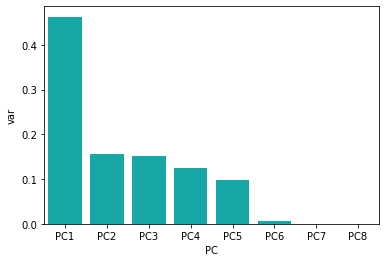

In [24]:
import seaborn as sns
sns.barplot(x = 'PC', y = 'var', data = pc_var_df, color = 'c');

In [25]:
print('Total Variance of First Four PC: ' , pc_var_df['var'].loc[0:3].sum())

Total Variance of First Four PC:  0.8944693525830238


I started with eight PCA components since total number of features are 8. I will keep 4 PC since the sum of varaince of this PC's are 90 percent.

# Problem 5(b)

In [26]:
loadings = pca.components_
print('Loadings: \n', loadings)

Loadings: 
 [[ 4.95951415e-01 -5.01733022e-01  3.25142980e-02 -5.04962227e-01
   4.96237987e-01  1.11300156e-17  2.31482629e-17  1.09622766e-17]
 [-2.44734692e-01  2.31540671e-01  8.94291660e-01 -2.06120761e-01
   2.10358046e-01  3.24293417e-17 -1.39808629e-17  5.62805425e-17]
 [-6.44569226e-17 -1.59992389e-17 -1.37506492e-18 -1.66605430e-16
  -7.25957933e-17 -3.96155287e-16 -7.07106781e-01 -7.07106781e-01]
 [-1.10518471e-17 -1.41084293e-16  3.26286365e-17  1.51756604e-16
  -1.74317556e-18  1.00000000e+00 -3.27918310e-16 -7.33821538e-17]
 [ 1.77678288e-17 -4.22869286e-17 -3.03449156e-17  3.18606339e-17
  -8.73950526e-18 -1.34666023e-16 -7.07106781e-01  7.07106781e-01]
 [ 4.95169837e-01 -6.62121736e-02  2.91115164e-01 -2.05162334e-01
  -7.89672817e-01  1.63905534e-17  4.48156406e-17  4.03907290e-17]
 [-6.70032803e-01 -5.04882009e-01 -8.74393510e-02 -4.50100394e-01
  -2.93111232e-01 -7.98823192e-18  1.04633003e-16  1.04181325e-16]
 [ 9.36496333e-17 -6.59820428e-01  3.26789793e-01  6.7664

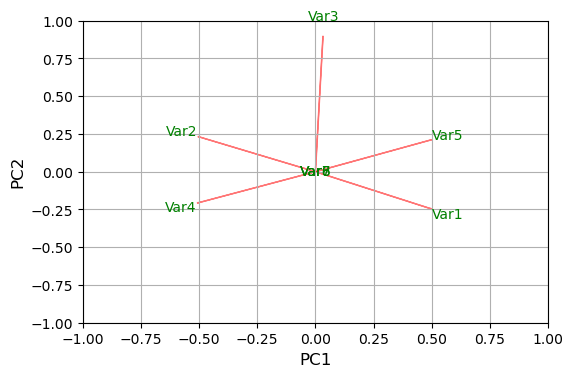

In [27]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    sclaex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.figure(figsize=(6,4), dpi=100)
    for i in range(n):
        plt.arrow(0,0,coeff[i,0], coeff[i,1],color = 'r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]*1.15, coeff[i,1] * 1.15,'Var'+str(i+1),color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]*1.15, coeff[i,1] * 1.15, labels[i],color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('PC{}'.format(1), size=12)
    plt.ylabel("PC{}".format(2), size=12)
    plt.grid()

myplot(pc[:,0:2], np.transpose(pca.components_[0:2,:]));

 Variable 1 hase more controbution on PC1 and less contribution pn PC2 where variable 3 has on more on PC2 and less on PC1. Variable 4 has less contribution on both PC. There are not much correlations between variables

# Problem 5(C)

PCA in this case was useful some way beacuse it reduced the dimention from 8 to 4 but most of the variables are not correalated